#### 匯入模組

In [ ]:
# 資料輸入輸出所需套件：
import numpy as np
import os

# 深度學習所需套件：
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape # new! 
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D # new! 
from tensorflow.keras.optimizers import RMSprop # new! 

# 繪圖所需套件：
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### 載入資料集

In [7]:
data_dir='/content/drive/My Drive/Colab Notebooks/F1383_Sample/Ch14/quickdraw_data'  #註：請記得依你存放的位置彈性修改路徑
input_images = data_dir + "/apple.npy"

In [ ]:
data = np.load(input_images)

In [10]:
data.shape

(144722, 784)

In [11]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

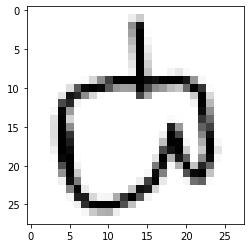

In [15]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

建構鑑別器 (discriminator) 

In [2]:
def build_discriminator(depth=64, p=0.4):

    # 定義輸入
    image = Input((img_w,img_h,1))
    
    # 卷積層
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # 輸出層
    prediction = Dense(1, activation='sigmoid')(conv4)
    
    # 定義模型
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [ ]:
discriminator = build_discriminator()

In [19]:
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

In [ ]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, 
                               decay=6e-8, 
                               clipvalue=1.0), 
                      metrics=['accuracy'])

In [ ]:
# discriminator.compile(loss='binary_crossentropy', 
#                 optimizer=Adam(lr=0.0008, 
#                        clipvalue=1.0), 
#                        metrics=['accuracy'])

建構生成器 generator

In [21]:
z_dimensions = 32

In [23]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # 定義輸入
    noise = Input((latent_dim,))
    
    # 第 1 密集層
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # 反卷積層
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # 輸出層
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # 定義模型   
    model = Model(inputs=noise, outputs=image)
    
    return model

In [24]:
generator = build_generator()

In [25]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0   

建立對抗式神經網路

In [26]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [27]:
discriminator.trainable = False

In [28]:
pred = discriminator(img)

In [29]:
adversarial_model = Model(z, pred)

In [31]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(learning_rate=0.0004, 
                                   decay=3e-8, 
                                   clipvalue=1.0), 
                          metrics=['accuracy'])

In [33]:
def train(train_round =2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(train_round):
        
        # 從真影像資料集中取樣： 
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # 生成假影像：
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # 將真假影像串起來, 方便一併輸入鑑別器：
        x = np.concatenate((real_imgs,fake_imgs))
        
        # 標籤 y, 提供給鑑別器： 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # 訓練鑑別器： 
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # 設定對抗式神經網路的輸入雜訊與標籤 y
        # (生成器希望鑑別器能誤判為真, 所以 y=1)：
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # 訓練對抗式神經網路： 
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # 定時顯示進度與生成影像：
        if (i+1)%100 == 0:

            print('train_round #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

train_round #99
99: [D loss: 0.237281, acc: 0.987453]  [A loss: 10.200616, acc: 0.066604]


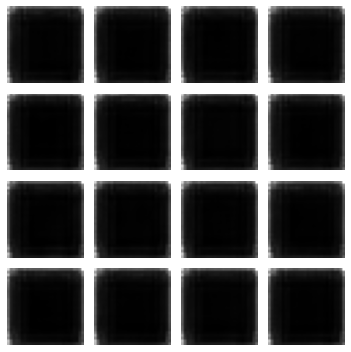

train_round #199
199: [D loss: 0.370273, acc: 0.880457]  [A loss: 7.030249, acc: 0.173759]


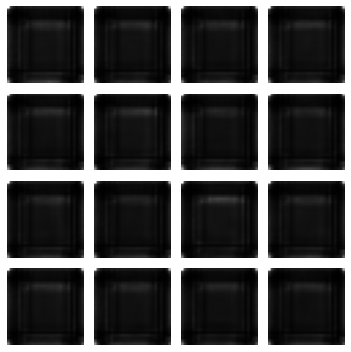

train_round #299
299: [D loss: 0.473176, acc: 0.776142]  [A loss: 4.945849, acc: 0.238634]


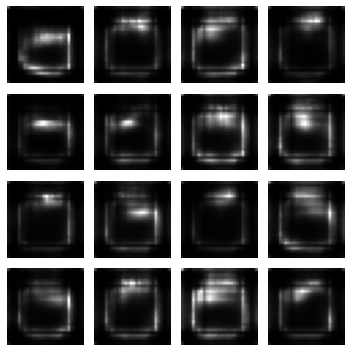

train_round #399
399: [D loss: 0.519582, acc: 0.734708]  [A loss: 3.927079, acc: 0.237312]


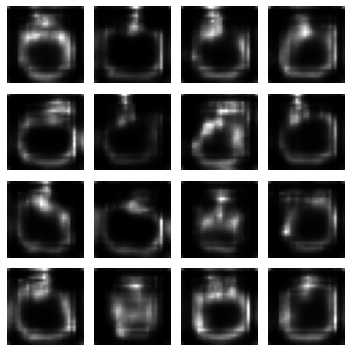

train_round #499
499: [D loss: 0.532540, acc: 0.724887]  [A loss: 3.365313, acc: 0.227001]


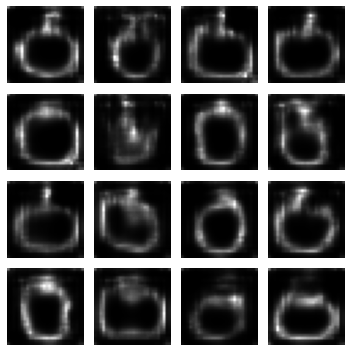

train_round #599
599: [D loss: 0.530844, acc: 0.727065]  [A loss: 3.061927, acc: 0.208407]


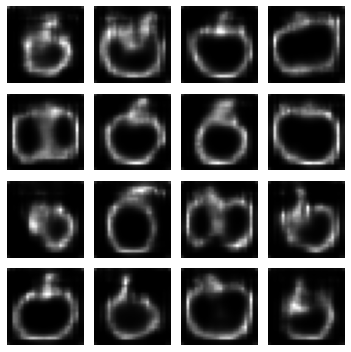

train_round #699
699: [D loss: 0.518349, acc: 0.737147]  [A loss: 2.901727, acc: 0.193334]


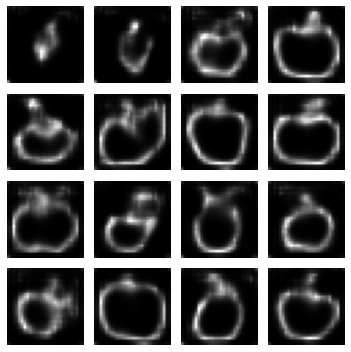

train_round #799
799: [D loss: 0.507090, acc: 0.745468]  [A loss: 2.811391, acc: 0.179697]


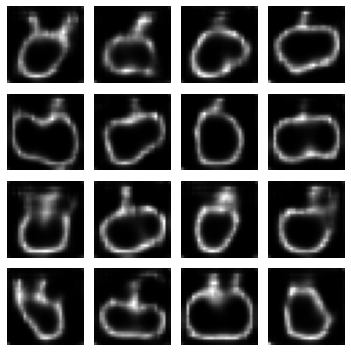

train_round #899
899: [D loss: 0.493919, acc: 0.754575]  [A loss: 2.765426, acc: 0.167756]


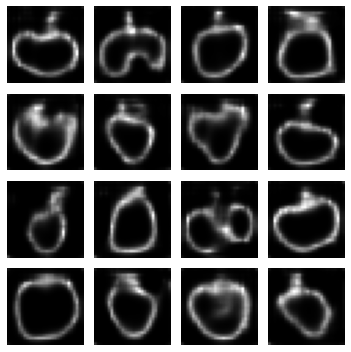

train_round #999
999: [D loss: 0.483041, acc: 0.761946]  [A loss: 2.735264, acc: 0.158346]


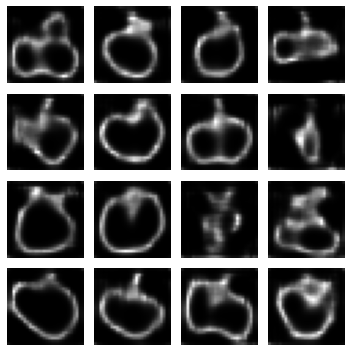

train_round #1099
1099: [D loss: 0.472533, acc: 0.769151]  [A loss: 2.728843, acc: 0.149937]


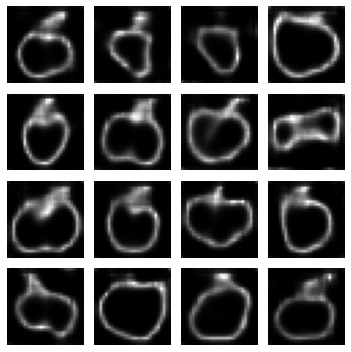

train_round #1199
1199: [D loss: 0.462880, acc: 0.775409]  [A loss: 2.727059, acc: 0.142886]


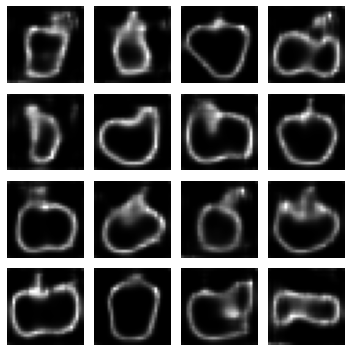

train_round #1299
1299: [D loss: 0.452299, acc: 0.782221]  [A loss: 2.740229, acc: 0.136409]


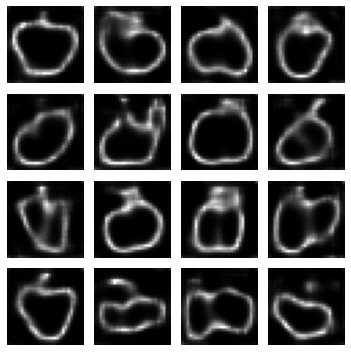

train_round #1399
1399: [D loss: 0.443078, acc: 0.788225]  [A loss: 2.755205, acc: 0.130428]


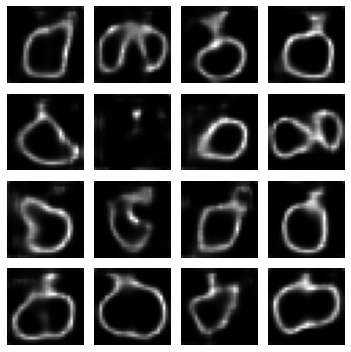

train_round #1499
1499: [D loss: 0.433644, acc: 0.793857]  [A loss: 2.772102, acc: 0.125964]


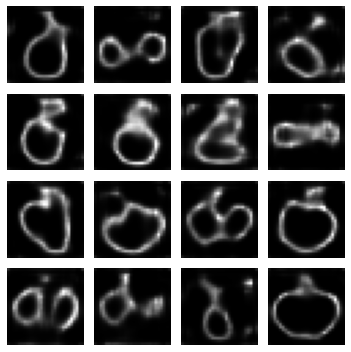

train_round #1599
1599: [D loss: 0.425145, acc: 0.799259]  [A loss: 2.792006, acc: 0.121023]


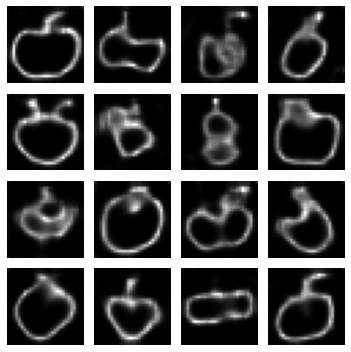

train_round #1699
1699: [D loss: 0.417894, acc: 0.803694]  [A loss: 2.808610, acc: 0.116829]


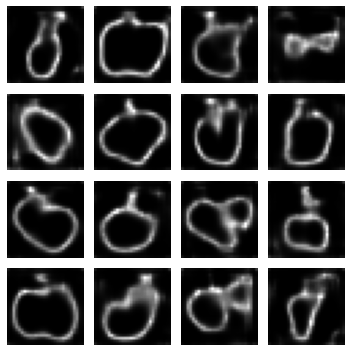

train_round #1799
1799: [D loss: 0.411681, acc: 0.807482]  [A loss: 2.823591, acc: 0.113279]


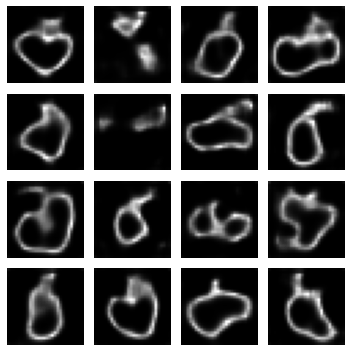

train_round #1899
1899: [D loss: 0.406043, acc: 0.810990]  [A loss: 2.833532, acc: 0.109766]


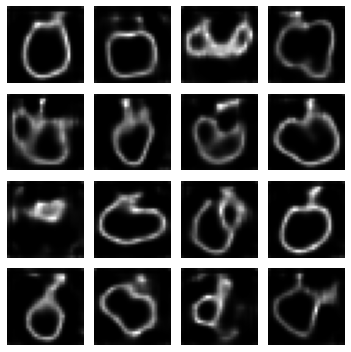

train_round #1999
1999: [D loss: 0.400813, acc: 0.814255]  [A loss: 2.844120, acc: 0.106698]


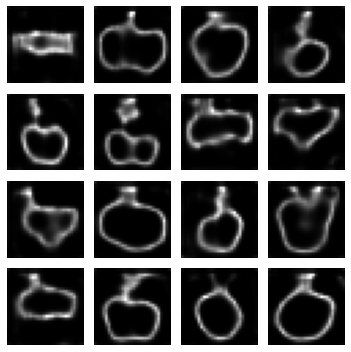

In [34]:

a_metrics_complete, d_metrics_complete = train()